Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Taylon xxxxx (RA: 0000000)
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)

# Lista 01

## Tarefa

Trabalhar com a base de dados U.S. Airline Traffic Data, a qual contém informações referentes ao tráfego aéreo mensal norte-americano no período de 2003 a 2023, disponibilizadas pelo U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics. Em particular, vamos explorar a série temporal do número total de vôos (domésticos e internacionais).

Explorar um modelo linear para a previsão considerando que o horizonte de predição é L = 1 (passos à frente da série temporal).

## Dataset

* [Lista01\air traffic.csv](https://www.kaggle.com/datasets/yyxian/u-s-airline-traffic-data/data)

* This dataset provides U.S. monthly airline traffic from 2003 to 2023, including number of passengers, number of flights, revenue passenger-miles (RPM), available seat-miles (ASM) and load factor.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np
# import datetime as dt
# from itertools import chain
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from scipy.interpolate import interp1d

In [2]:
df_original = pd.read_csv("air traffic.csv")
df_original.describe()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
count,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000
mean,2012.879518,6.445783,5.520971e+07,7.392209e+06,6.260192e+07,706750.710843,64736.172691,771486.883534,4.957803e+07,1.918103e+07,6.875906e+07,6.131822e+07,2.413903e+07,8.545724e+07,79.938394,77.304940,79.286305
std,6.002817,3.442803,1.044055e+07,2.020273e+06,1.229211e+07,107054.971522,12129.622461,115686.728629,1.035558e+07,5.711621e+06,1.548875e+07,8.996673e+06,5.650437e+06,1.382385e+07,8.860562,10.907145,8.895700
min,2003.000000,1.000000,2.877290e+06,1.366090e+05,3.013899e+06,217262.000000,4996.000000,222280.000000,2.551127e+06,3.567620e+05,2.907889e+06,1.948908e+07,1.541419e+06,2.103050e+07,13.090000,23.150000,13.830000
25%,2008.000000,3.000000,5.098217e+07,6.395022e+06,5.766458e+07,662000.000000,61615.000000,727898.000000,4.458029e+07,1.660284e+07,6.182568e+07,5.655552e+07,2.173119e+07,7.919780e+07,77.720000,76.430000,76.940000
50%,2013.000000,6.000000,5.620010e+07,7.419187e+06,6.389913e+07,709933.000000,66557.000000,779011.000000,4.985794e+07,1.968901e+07,6.900519e+07,6.088909e+07,2.464572e+07,8.505191e+07,82.120000,79.910000,81.580000
75%,2018.000000,9.000000,6.089213e+07,8.567847e+06,6.944743e+07,781804.000000,71924.000000,848650.000000,5.568257e+07,2.266760e+07,7.803987e+07,6.626877e+07,2.770535e+07,9.255187e+07,85.240000,82.930000,84.070000
max,2023.000000,12.000000,7.537816e+07,1.243262e+07,8.781077e+07,890938.000000,82681.000000,964102.000000,7.226790e+07,3.137600e+07,1.036439e+08,8.199740e+07,3.532619e+07,1.173122e+08,89.960000,89.440000,89.140000


In [3]:
df_original['Date'] = pd.to_datetime(df_original[['Year', 'Month']].assign(day=1))
df_original.set_index('Date', inplace=True)
df_original = df_original[['Flt']]

## Item [a]
Exiba o gráfico da série temporal completa. Numa inspeção visual simples, é possível reconhecer ao menos três faixas distintas de comportamento aproximadamente “regular” na série: 
    
* (i) Jan/2003 a Ago/2008; 
* (ii) Set/2008 a Dez/2019; 
* (iiI) Jan/2020 a Set/2023.

Discuta possíveis razões históricas/econômicas para as
transições de comportamento.

In [4]:
def _is_list_or_set(a):
    if isinstance(a, list):
        return True
    if isinstance(a, set):
        return True
    return False

def to_datetime(a):
    if _is_list_or_set(a):
        a_new = []
        for ai in a:
            a_new.append(to_datetime(ai))
        if isinstance(a, set):
            a_new = set(a_new)
        return a_new
    else:
        return pd.to_datetime(a)

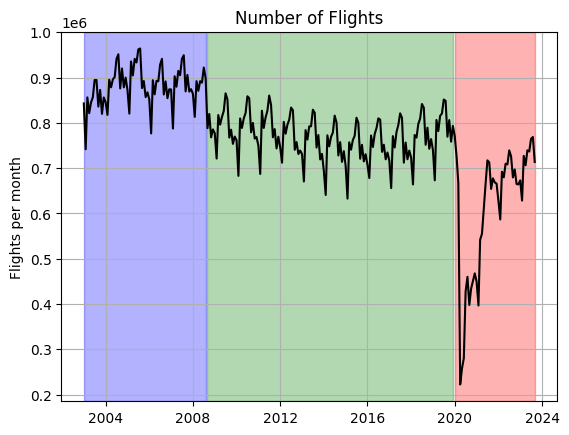

In [5]:
plt.plot(df_original['Flt'], color='black', linestyle='-')

date_regions = [
    ('2003-01-01', '2008-08-01'),
    ('2008-09-01', '2019-12-01'),
    ('2020-01-01', '2023-09-01')
]
date_regions = to_datetime(date_regions)

plt.axvspan(date_regions[0][0], date_regions[0][1], color='blue', alpha=0.3)
plt.axvspan(date_regions[1][0], date_regions[1][1], color='green', alpha=0.3)
plt.axvspan(date_regions[2][0], date_regions[2][1], color='red', alpha=0.3)

plt.ylabel('Flights per month')
plt.title('Number of Flights')
plt.grid(True)
plt.show()

**Resposta**

O primeiro período (azul) é de certa normalidade na economia americana. O início do período em verde é marcado pela crise financeira do _subprime_ (estouro da bolha imobiliária nos EUA devido a empréstimos sem lastro e preços de imóveis inflacionados). O período em vermelho corresponde à crise sanitária causada pela pandemia de Covid-19.

**Série Temporal Alternativa**

A série original apresenta um caráter cíclico (com frequência anual) e _serrilhado_. Foram avaliadas duas alternativas para deixar a série temporal mais suave. Como os meses do ano não tem o mesmo número de dias, uma primeira tentativa foi de calcular o número médio de vôos por dia para cada mês da série. Uma segunda tentativa foi de calcular o número de vôos diários, mas limitando aos dias úteis de cada mês.

Nota-se que a série temporal de média mensal de vôos por dia se mostra mais suave que a série original. O efeito é mais pronunciado no mês de fevereiro. Já a série temporal de total mensal de vôos dividido pelo número de dias úteis não teve uma reposta adequada. 

Optou-se por utilizar a média mensal de vôos por dia nas análises posteriores.

In [6]:
df_original['Days_in_month'] = df_original.index.days_in_month
df_original['Flt_per_day'] = df_original['Flt'] / df_original['Days_in_month']

def get_workdays(date):
    year = date.year
    month = date.month
    start_date = pd.Timestamp(year, month, 1)
    if month == 12:
        month = 0
        year = year+1
    end_date = pd.Timestamp(year, month+1, 1) - pd.Timedelta(1)
    return len(pd.bdate_range(start_date, end_date))

df_original['Workdays'] = [get_workdays(i) for i in df_original.index]
df_original['Flt_per_workday'] = df_original['Flt'] / df_original['Workdays']

In [7]:
def year_plots(years, columns, titles):
    date_format = DateFormatter("%b")

    _, axs = plt.subplots(1, len(columns), figsize=(len(columns)*5, 5))

    for i, (column,title) in enumerate(zip(columns, titles)):
        for year in years:
            axs[i].plot(df_original.loc[f'{years[0]}-01-01':f'{years[0]+1}-01-01'].index,
                        df_original.loc[f'{year}-01-01':f'{year+1}-01-01'][column],
                        linestyle='-', label=year)
        axs[i].xaxis.set_major_formatter(date_format)
        axs[i].set_title(title)
        axs[i].legend()
        axs[i].grid(True)
    axs[0].set_ylabel('Number of Flights')
    plt.tight_layout()
    plt.show()

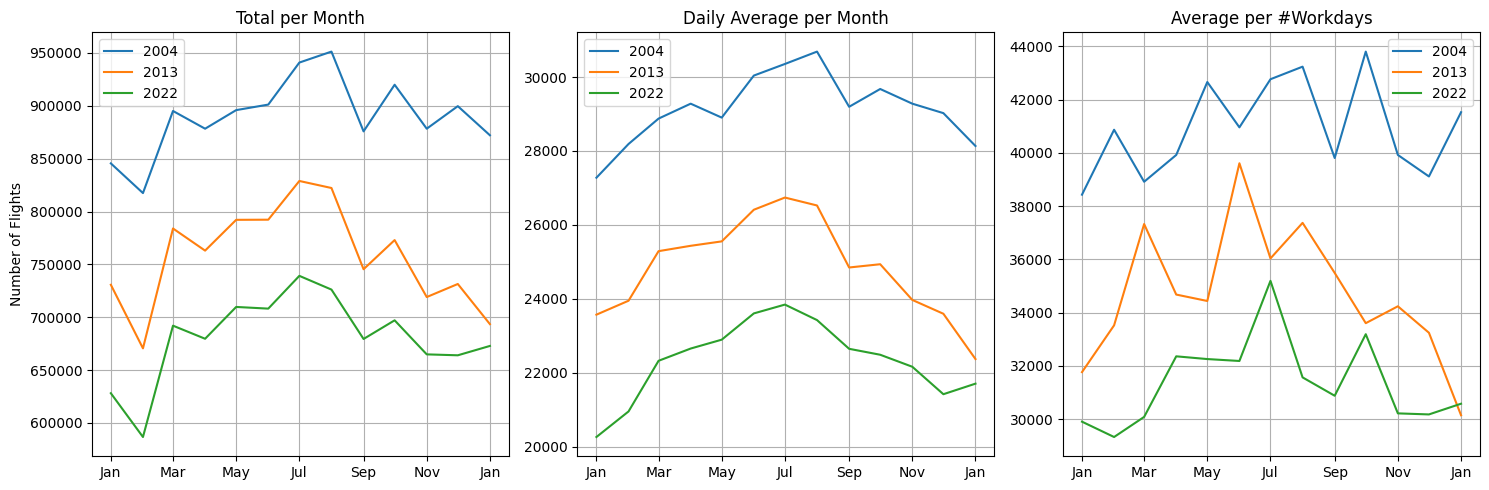

In [8]:
year_plots([2004, 2013, 2022],
           ['Flt', 'Flt_per_day', 'Flt_per_workday'],
           ['Total per Month', 'Daily Average per Month', 'Average per #Workdays'])

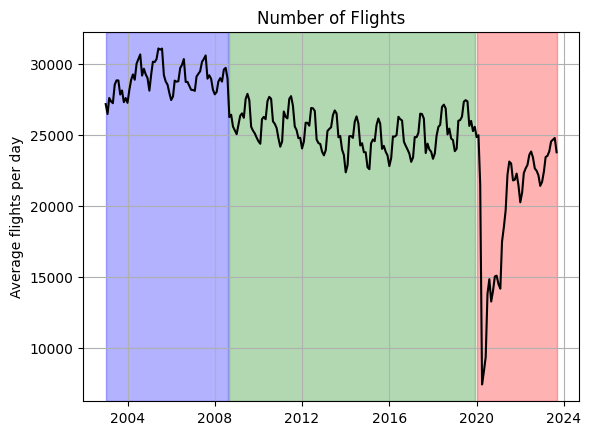

In [9]:
plt.plot(df_original['Flt_per_day'],
         color='black', linestyle='-', marker='',
         label='Total')

plt.axvspan(date_regions[0][0], date_regions[0][1], color='blue', alpha=0.3)
plt.axvspan(date_regions[1][0], date_regions[1][1], color='green', alpha=0.3)
plt.axvspan(date_regions[2][0], date_regions[2][1], color='red', alpha=0.3)

plt.ylabel('Average flights per day')
plt.title('Number of Flights')
plt.grid(True)
plt.show()

## Item [b]

Divida a série em dois conjuntos:

* (i) **treinamento** e **validação**: com amostras de 2003 a 2019.
* (ii) **teste**: com amostras de 2020 a 2023.

Faça a análise de desempenho do preditor linear ótimo, no sentido de quadrados mínimos irrestrito considerando:

### Item [b1]

A progressão do valor da raiz quadrada do erro quadrático médio (RMSE, do inglês _root mean squared
error_), junto aos dados de validação, em função do número de entradas (K) do preditor (desde K = 1
a K = 24). Apresente o gráfico obtido e busque tecer conjecturas sobre os motivos subjacentes a seu
comportamento.

Para que todos o treinamento e validação sejam feitos com os mesmos conjuntos de dados, foram retiradas todas as linhas com valores não numéricos (_nan_).

In [35]:
df = df_original[['Flt','Days_in_month','Flt_per_day']]
df = df.rename(columns={'Flt_per_day':'y'})
for k in range(24):
    df[f'x_{k+1}'] = df['y'].shift(periods=k+1)
df = df[24:]

In [36]:
limits = {
    'train-validation':('2003-01-01', '2019-12-01'),
    'test':('2020-01-01', '2023-09-01')
}

df_train_val = df.loc[limits['train-validation'][0]:limits['train-validation'][1]]
df_test = df.loc[limits['test'][0]:limits['test'][1]]

print(f'Total number of data points: {len(df)}')
print(f'Number of train + validation data points: {len(df_train_val)}')
print(f'Number of test data points: {len(df_test)}')

Total number of data points: 225
Number of train + validation data points: 180
Number of test data points: 45


Como todas variáveis de entrada para os modelos lineares são de mesma natureza, uma modificação na escala dos dados não terá qualquer impacto nos resultados dos ajustes dos modelos lineares. No exemplo abaixo de um modelo linear simples (sem normalização), os resultados com e sem modificação na escala dos dados de entrada são idênticos.

In [47]:
linear_model = LinearRegression()
columns = ['x_1','x_2']
n_train = 140
y_train = df_train_val[:n_train]['y']
X_train = df_train_val[:n_train][columns]
y_validation = df_train_val[n_train:]['y']
X_validation = df_train_val[n_train:][columns]

print('No scaling')
linear_model.fit(X_train, y_train)
print(f'  Coeficients: {linear_model.intercept_} & {linear_model.coef_}')
y_train_predict = linear_model.predict(X_train)
rmse = root_mean_squared_error(y_train_predict, y_train)
print(f'  test rmse = {rmse:0.2f}')
y_validation_predict = linear_model.predict(X_validation)
rmse = root_mean_squared_error(y_validation_predict, y_validation)
print(f'  validation rmse = {rmse:0.2f}')


scaler = MinMaxScaler()
scaler.set_output(transform="pandas")
all_x_columns = [f'x_{k+1}' for k in range(24)]
scaler.fit(df_train_val[all_x_columns])

X_train_scaled = scaler.transform(df_train_val[:n_train][all_x_columns])[columns]
X_validation_scaled = scaler.transform(df_train_val[n_train:][all_x_columns])[columns]

print('With scaling')
linear_model.fit(X_train_scaled, y_train)
print(f'  Coeficients: {linear_model.intercept_} & {linear_model.coef_}')
y_train_predict_scaled = linear_model.predict(X_train_scaled)
rmse_scaled = root_mean_squared_error(y_train_predict_scaled, y_train)
print(f'  test rmse = {rmse_scaled:0.2f}')
y_validation_predict_scaled = linear_model.predict(X_validation_scaled)
rmse = root_mean_squared_error(y_validation_predict_scaled, y_validation)
print(f'  validation rmse = {rmse:0.2f}')


No scaling
  Coeficients: 2357.791675445802 & [ 1.08601439 -0.17547108]
  test rmse = 788.91
  validation rmse = 854.33
With scaling
  Coeficients: 22725.646979800284 & [ 9490.64005956 -1533.43531524]
  test rmse = 788.91
  validation rmse = 854.33


Durante as iterações da rotina de ajuste do modelo linear, o algoritmo teve dificuldades de convergência quando foram utilizados valores alto de k (>15). Ao modificar a escala dos dados de entrada o algoritmo não apresentou problemas. Deste modo, as análises seguintes serão feitas com os dados de entrada escalados.

Como existe dependência entre os dados observados, o processo de validação cruzada _clássico_ não pode ser utilizado. Foi utilizada a rotina implementada no pacote Scikit-Learn, que segue as ideias apresentadas em [1]. Os dados de validação ($I(v)$) são definidos em índices posteriores aos dos dados de treinamento ($I(t)$):

$\min{}_{i∈I(t), j∈I(v)} |i − j| > h > 0$

Foi implementada uma rotina que segue a figura abaixo (Fonte: [2]):

![Validação cruzada de série temporal](fXZ6k.png)


[1] Sylvain Arlot, Alain Celisse "A survey of cross-validation procedures for model selection," Statistics Surveys, Statist. Surv. 4(none), 40-79, (2010). http://dx.doi.org/10.1214/09-SS054

[2] stats.stackexchange.com. "Using k-fold cross-validation for time-series model selection". http://web.archive.org/web/20240221145617/https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [48]:
validation_ratio = 0.2
folds = int(np.floor(1/validation_ratio-1))

In [16]:
def get_train_validation(df, validation_ratio, fold_number=1):
    folds = np.floor(1/validation_ratio-1).astype(int)
    if fold_number > folds or fold_number < 1:
        return None
    validation_size = np.floor(len(df_train_val) * validation_ratio).astype(int)
    validation_index = len(df_train_val) - (folds - fold_number + 1) * validation_size
    return df[:validation_index], df[validation_index:validation_index+validation_size]

In [17]:
def train_model(model, k_variables, df):
    variables_list = [f'x_{i+1}' for i in range(k_variables)]
    X_train = df[variables_list]
    y_train = df['y']
    model.fit(X_train, y_train)

def get_predict(model, k_variables, df):
    variables_list = [f'x_{i+1}' for i in range(k_variables)]
    X = df[variables_list]
    y_predict = model.predict(X)
    return y_predict

def get_errors(model, k_variables, df):
    y = df['y']
    y_predict = get_predict(model, k_variables, df)
    rmse = root_mean_squared_error(y, y_predict)
    mae = mean_absolute_percentage_error(y, y_predict)
    return rmse, mae

def split_train_and_get_errors(model, k_variables, df,
                         validation_ratio, fold_number):
    folds = np.floor(1/validation_ratio-1)
    if fold_number > folds:
        return None

    df_train, df_validation = get_train_validation(
        df=df,
        validation_ratio=validation_ratio,
        fold_number=fold_number)

    train_model(
        model=model,
        k_variables=k_variables,
        df=df_train)

    rmse_train, mae_train = get_errors(
        model=model,
        k_variables=k_variables,
        df=df_train)
    rmse_validation, mae_validation = get_errors(
        model=model,
        k_variables=k_variables,
        df=df_validation)

    return rmse_train, mae_train, rmse_validation, mae_validation

Antes de seguir com o teste de diversos modelos lineares, foram propostos três modelos _naïve_:

1. Igual ao passo de tempo anterior: $\hat{y}(t_i) = y(t_{i-1})$
1. Igual ao passo de tempo 12 meses atrás: $\hat{y}(t_i) = y(t_{i-12})$
1. Igual ao passo de tempo 12 meses atrás mais incremento entre 24 e 12 meses atrás: $\hat{y}(t_i) = y(t_{i-12}) + [y(t_{i-12}) - y(t_{i-24})] = 2 y(t_{i-12}) - y(t_{i-24})$

Os modelos _naïve_ foram propostos com base na natureza cíclica da série temporal em estudo. Os valores de **rmse** e **mae** destes modelos servirão como referência para os demais modelos a serem construídos.

In [49]:
naive_coefficients = [
    [1] + 23*[0],
    11*[0] + [1] + 12*[0],
    11*[0] + [2] + 11*[0] + [-1]
]

y_naive = [
    df_train_val['x_1'],
    df_train_val['x_12'],
    2*df_train_val['x_12'] - df_train_val['x_24']
    ]

In [69]:
rmse_naive = []

y = df_train_val['y']
X = df_train_val[all_x_columns]
model = LinearRegression()
for coefficients in naive_coefficients:
    def custom_scorer(estimator, X, y):
        y_pred = np.dot(X, coefficients)
        return root_mean_squared_error(y, y_pred)
    tscv = TimeSeriesSplit(n_splits=folds)
    scores = cross_val_score(model, X, y, cv=tscv, scoring=custom_scorer)
    rmse_naive.append(np.mean(scores))

print('RMSE naïve models:\n  ' +
      '\n  '.join([f'{i+1}. {x:0.2f}' for i,x in enumerate(rmse_naive)]))

RMSE naïve models:
  1. 861.25
  2. 765.83
  3. 950.38


In [70]:
rmse_validation_naive = []

for i_naive, y_naive_model in enumerate(y_naive):
    rmse, mae = 0., 0.
    for folder_number in range(folds):
        df_train, df_validation = get_train_validation(
            df=df_train_val,
            validation_ratio=validation_ratio,
            fold_number=folder_number+1)

        i1 = len(df_train)
        i2 = len(df_validation)
        rmse_ = root_mean_squared_error(y_naive_model[i1:i1+i2], df_validation['y'])
        rmse += rmse_
        print(f'model #{i_naive+1}: fold = {folder_number+1}, rmse = {rmse_:0.2f}, avg rmse = {rmse/(folder_number+1):0.2f}')

    rmse_validation_naive.append(rmse/folds)

print('RMSE naïve models:\n  ' +
      '\n  '.join([f'{i+1}. {x:0.2f}' for i,x in enumerate(rmse_validation_naive)]))

model #1: fold = 1, rmse = 836.92, avg rmse = 836.92
model #1: fold = 2, rmse = 842.64, avg rmse = 839.78
model #1: fold = 3, rmse = 874.45, avg rmse = 851.34
model #1: fold = 4, rmse = 890.99, avg rmse = 861.25
model #2: fold = 1, rmse = 1540.85, avg rmse = 1540.85
model #2: fold = 2, rmse = 491.98, avg rmse = 1016.42
model #2: fold = 3, rmse = 461.02, avg rmse = 831.28
model #2: fold = 4, rmse = 569.48, avg rmse = 765.83
model #3: fold = 1, rmse = 1941.96, avg rmse = 1941.96
model #3: fold = 2, rmse = 680.91, avg rmse = 1311.43
model #3: fold = 3, rmse = 579.01, avg rmse = 1067.29
model #3: fold = 4, rmse = 599.64, avg rmse = 950.38
RMSE naïve models:
  1. 861.25
  2. 765.83
  3. 950.38


Observa-se que os resultados de RMSE são relativamente próximos entre os três modelos _naïve_. Em uma inspeção gráfica a primeira proposta de modelo parece ser melhor que as outras duas. Uma avaliação do gráfico do erro cometido por estes modelos demonstra que na verdade os modelos tem níveis de erro parecidos, mas com diferentes frequências.

Por ter os menores valores de RMSE, além de apresentar um comportamento de erro mais _comportado_ que as outras alternativas, foi escolhido o segundo modelo _naïve_ para ser utilizado como base para comparação com os demais modelos.

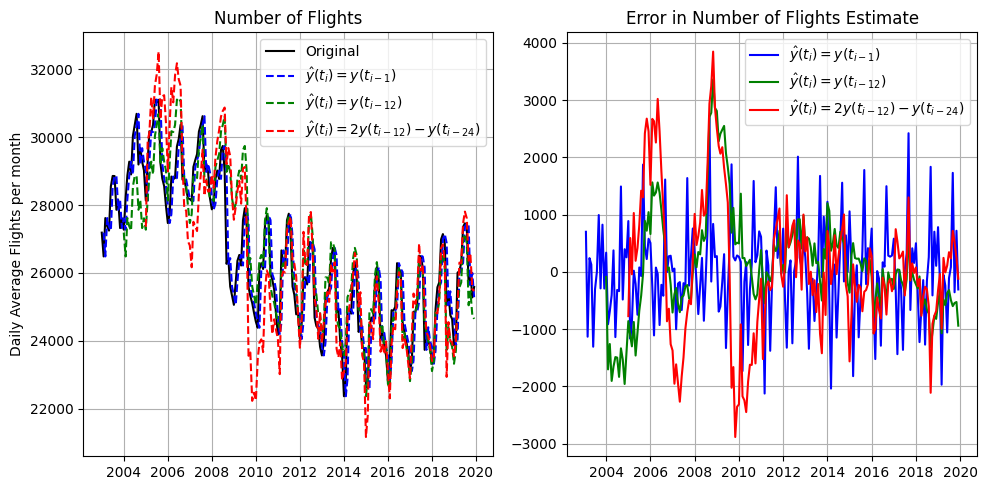

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(df_train_val['y'], color='black', linestyle='-', label='Original')
axs[0].plot(y_naive[0], color='blue', linestyle='--', label=r'$\hat{y}(t_i) = y(t_{i-1})$')
axs[0].plot(y_naive[1], color='green', linestyle='--', label=r'$\hat{y}(t_i) = y(t_{i-12})$')
axs[0].plot(y_naive[2], color='red', linestyle='--', label=r'$\hat{y}(t_i) =2 y(t_{i-12}) - y(t_{i-24})$')

axs[0].set_ylabel('Daily Average Flights per month')
axs[0].set_title('Number of Flights')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(y_naive[0]-df_train_val['y'], color='blue', linestyle='-', label=r'$\hat{y}(t_i) = y(t_{i-1})$')
axs[1].plot(y_naive[1]-df_train_val['y'], color='green', linestyle='-', label=r'$\hat{y}(t_i) = y(t_{i-12})$')
axs[1].plot(y_naive[2]-df_train_val['y'], color='red', linestyle='-', label=r'$\hat{y}(t_i) =2 y(t_{i-12}) - y(t_{i-24})$')

axs[1].set_title('Error in Number of Flights Estimate')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rmse_validation_naive = rmse_validation_naive[1]
y_naive = y_naive[1]

Foi definido utilizar o modelo Elastic_Net. A busca pelo melhor modelo para cada valor de k foi feita com uma busca em grid por parâmetros ótimos de _alpha_ e *l1_ratio*.

In [ ]:
param_grid = {
    'alpha': [0., 0.1, 0.2, 0.5, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

rmse_train_list = []
rmse_validation_list = []
alpha_list = []
l1_ratio_list = []

best_model = None

for k in range(24):
    rmse_train_list.append(float('inf'))
    rmse_validation_list.append(float('inf'))
    alpha_list.append(0)
    l1_ratio_list.append(0)

    for alpha in param_grid['alpha']:
        for l1_ratio in param_grid['l1_ratio']:
            if alpha==0:
                linear_model = LinearRegression()
                if l1_ratio != param_grid['l1_ratio'][0]:
                    continue
            else:
                linear_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

            rmse_train, rmse_validation = 0., 0.
            for folder_number in range(folds):
                errors = split_train_and_get_errors(
                    model=linear_model,
                    k_variables=k+1,
                    df=df,
                    validation_ratio=validation_ratio,
                    fold_number=folder_number+1)
                rmse_train += errors[0]
                rmse_validation += errors[2]
            rmse_train = rmse_train/folds
            rmse_validation = rmse_validation/folds
            if (rmse_validation) < rmse_validation_list[-1]:
                rmse_train_list[-1] = rmse_train
                rmse_validation_list[-1] = rmse_validation
                alpha_list[-1] = alpha
                l1_ratio_list[-1] = l1_ratio

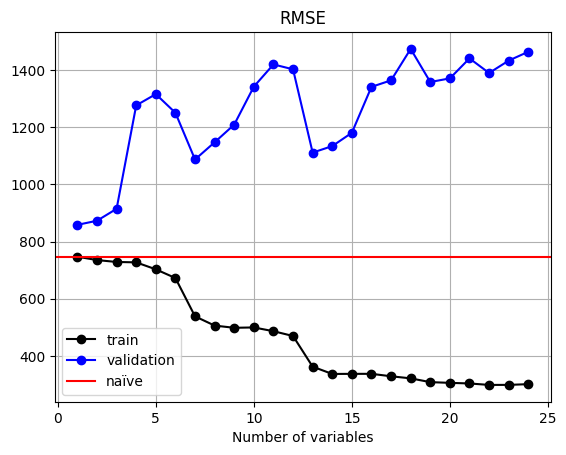

In [ ]:
plt.plot(range(1,25), rmse_train_list, color='black', linestyle='-', marker='o', label='train')
plt.plot(range(1,25), rmse_validation_list, color='blue', linestyle='-', marker='o',label='validation')
plt.axhline(y=rmse_validation_naive, color='red', linestyle='-', label='naïve')

plt.xlabel('Number of variables')
plt.title('RMSE')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
i_best = rmse_validation_list.index(min(rmse_validation_list))
k_best = i_best + 1
print('Best Model')
print(f'  k = {k_best}')
print(f'  alpha = {alpha_list[i_best]}')
print(f'  l1_ratio = {l1_ratio_list[i_best]}')

Best Model
  k = 1
  alpha = 0.0
  l1_ratio = 0.1


### Item [b2]

O gráfico com as amostras de teste da série temporal e as respectivas estimativas geradas pela melhor
versão do preditor (i.e., usando o valor de K que levou ao mínimo erro de validação). Obtenha, também, o RMSE e o erro percentual absoluto médio (MAPE, do inglês _mean absolute percentage error_) para o conjunto de teste.

In [ ]:
if alpha_list[i_best]==0:
    best_model = LinearRegression()
else:
    best_model = ElasticNet(alpha=alpha_list[i_best], l1_ratio=l1_ratio_list[i_best])
train_model(
    model=best_model,
    k_variables=k_best,
    df=df_train_val[k_best:])

y_predict = get_predict(
    model=best_model,
    k_variables=k_best,
    df=df[k_best:])


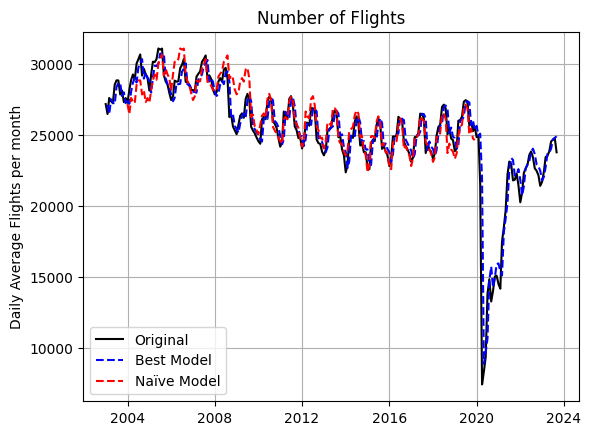

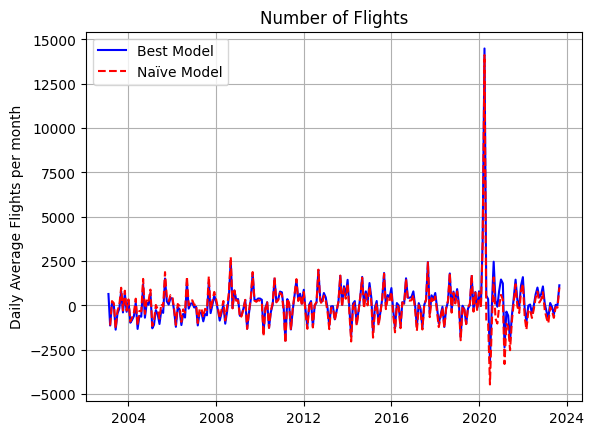

In [ ]:
plt.plot(df['y'], color='black', linestyle='-', label='Original')
plt.plot(df.index[k_best:], y_predict, color='blue', linestyle='--', label='Best Model')
plt.plot(y_naive, color='red', linestyle='--', label='Naïve Model')

scaler.inverse_transform(df[f'x_{k+1}'].values.reshape(-1, 1))

plt.ylabel('Daily Average Flights per month')
plt.title('Number of Flights')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df.index[k_best:], y_predict-df['y'][k_best:], color='blue', linestyle='-', label='Best Model')
plt.plot(df['y'][k_best:].shift(1)-df['y'][k_best:], color='red', linestyle='--', label='Naïve Model')

scaler.inverse_transform(df[f'x_{k+1}'].values.reshape(-1, 1))

plt.ylabel('Daily Average Flights per month')
plt.title('Number of Flights')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_test_predict = get_predict(
    model=best_model,
    k_variables=k_best,
    df=df_test)

rmse = root_mean_squared_error(df_test['y'], y_test_predict)
mae = mean_absolute_percentage_error(df_test['y'], y_test_predict)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 2437.2625693937994
MAE: 0.08557851938990509


### Item [b3]

O gráfico com as amostras apenas dos dois últimos anos (2022 e 2023) e as estimativas geradas pelo
melhor preditor, além dos respectivos valores de RMSE e MAPE.

## Item [c]

Repita o procedimento detalhado nos itens **b1** e **b2**, mas adotando a seguinte divisão dos dados:

* (i) **treinamento**: amostras de 2003 a 2019.
* (ii) **validação**: amostras de 2020 e 2021.
* (iii) **teste**: amostras de 2022 e 2023.

Discuta os resultados obtidos e faça uma comparação com o cenário anterior (especialmente
com o que foi obtido no item **b3**).

In [ ]:
#